In [30]:
lambda <- scan(file = "C:/Users/Daniel Choi/Desktop/comp-coursework/MATH4432/HW3/lambda.txt")
loglam <- log(lambda, base=10)
train <- read.table(file = 'C:/Users/Daniel Choi/Desktop/comp-coursework/MATH4432/HW3/train.txt', sep = '\t', header = TRUE)

X = train[,2:21]
y = train[,1]

calc_p <- function(X, beta) {
  beta = as.vector(beta)
  return(exp(X%*%beta) / (1+ exp(X%*%beta)))
}  

### TODO: Implement the penalized logistic regression

In [19]:
manualReg <- function(X, y, lambda) {
  
  n  <- nrow(X)
  x_col  <- ncol(X)
  
  #Centering, Scaling
  
  ym <- mean(y)
  y  <- y-ym
  Xm <- colMeans(X)
  X <- scale(X,center = T,scale = F)
  Xsd <- sqrt(colMeans(X^2))
  X <- apply(X,MARGIN = 1,function(X,sd) X/sd,sd=Xsd)
  X <- t(X)
  
  ns <- length(lambda)
  beta <- matrix(0,x_col,ns)
  
  for(i in 1:ns) {
    
    if (i == 1){
      beta_old <- beta[,1]
    }
    else {
      beta_old <- beta[, i-1]
    }

    p <- as.vector(calc_p(X, beta_old))
    W  <- diag(p*(1-p)) 
    
    lambda_matrix <- diag(lambda[i], x_col)
    d1 <- t(X) %*% (p - y) + 2 * lambda_matrix %*% beta_old
    d2 <- t(X) %*% W %*% X + 2 * lambda_matrix
    
    beta_change <- solve(d2) %*% (d1)
    beta[, i] <- beta_old - beta_change
    
  }
  beta <- beta/Xsd
  w0 <- ym - colSums(beta*Xm)
  beta <- rbind(w0,beta)

  beta <- list(w=beta,lambda=lambda,eigvalues=D)
  attr(beta, "class") <- "manualReg"
  
  return(beta)
}

In [20]:
predict.manualReg <- function(object, Xtest) {
  Xtest <- cbind(1,Xtest)
  Xtest <- t(t(Xtest))
  y_h <- Xtest %*% object$w
}

### TODO: Fit the penalized logistic regression using the training data

In [21]:
fit <- manualReg(X, y, lambda)

### TODO: With your fitted models, construct two solution path figures

##### Solution path A

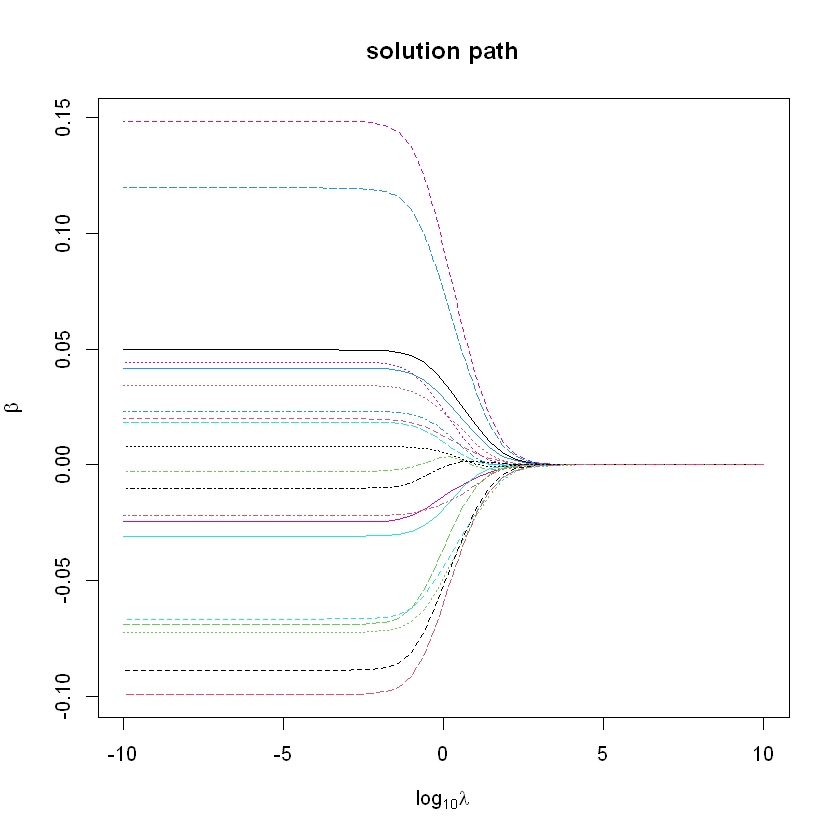

In [22]:
matplot(loglam,t(fit$w[-1,]),type="l",xlab=expression(log[10]*lambda),
         ylab=expression(beta),main="solution path")

##### Solution path B

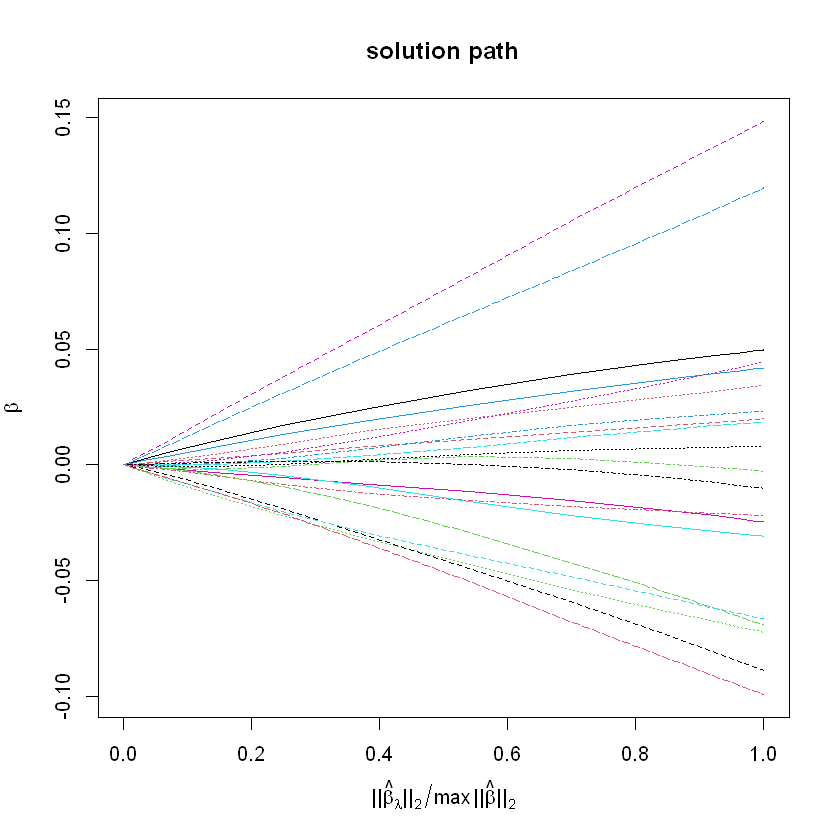

In [24]:
matplot(sqrt(colSums(fit$w[-1,]^2)/sum(fit$w[-1,length(lambda)]^2)),t(fit$w[-1,]),type="l",xlab=expression("||"*hat(beta)[lambda]*"||"[2]/max("||"*hat(beta)*"||"[2])),
        ylab=expression(beta),main="solution path")

### TODO: Implement a 10-fold cross validation

In [25]:
# Helper function
sigmoid <- function(x){
  return (1 / (1 + exp(-x)))
}

In [31]:
cv.manualReg <- function(X, y, lambda, center = F, scale = F, nfolds=10, ...){
  p <- ncol(X)
  n <- nrow(X)
  
  # decide the cv assignments
  idx <- round(sample(1:n)/n*nfolds)
  
  likelyhood  <- matrix(0,nfolds,length(lambda))
  
  # report settings
  message("Info: Number of variables: ", p)
  message("Info: Sample size: ", n)
  message("Info: Number of cv folds: ", nfolds)
  
  cat("start cv process......... total",nfolds,"validation sets \n")
  
  for(i in 1:nfolds) {
    cat(i,"-th validation set... \n")
    
    X_train <- X[idx!=i,]
    y_train <- y[idx!=i]
    
    X_test  <- X[idx==i,]
    y_test  <- y[idx==i]
    
    
    fit <- manualReg(X_train,y_train,lambda=lambda)
    
    y_hat <- predict(fit,X_test)

    phi <- sigmoid(y_hat)
    
    likelyhood[i,]  <- colMeans(y_test*log(phi) + (1-y_test)*log(1-phi))
  }
  
  cvsd <- sqrt(apply(likelyhood,MARGIN = 2,var)/(nfolds-1))
  cvm  <- colMeans(likelyhood)
  idx.max <- which.max(cvm)
  lambda.max <- fit$lambda[idx.max]
  
  manualReg.fit <- manualReg(X,y,lambda.max)
  
  cv_manual <- list(cvm=cvm,cvsd=cvsd,lambda=fit$lambda,lambda.max=lambda.max,manualReg.fit=manualReg.fit,likelyhood=likelyhood)
  attr(cv_manual,"class") <- "cv.manualReg"
  
  return(cv_manual)
}

In [27]:
set.seed(4432) 
nfold_10 <- cv.manualReg(X,y,lambda=lambda,center=T,scale=T,nfolds = 10)

Info: Number of variables: 20

Info: Sample size: 100

Info: Number of cv folds: 10



start cv process......... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


### TODO: Visulize the trend

In [28]:
plot.cv.manualReg <- function(object,width=0.01,...) {
  
  x <- log(object$lambda)
  y <- object$cvm
  
  upper <- y+object$cvsd/2
  lower <- y-object$cvsd/2
  ylim  <- range(upper,lower)
  barw  <- diff(range(x))*width
  
  plot(x,y,ylim = ylim,type = "n",xlab = "Log(Lambda)",ylab = "Predictive Likelihood",...)
  
  segments(x,lower,x,upper,col="darkgrey")
  segments(x-barw,lower,x+barw,lower,col="darkgrey")
  segments(x-barw,upper,x+barw,upper,col="darkgrey")
  points(x,y,col="red",pch=20)
  
  abline(v=log(object$lambda.max),lty=3)
}

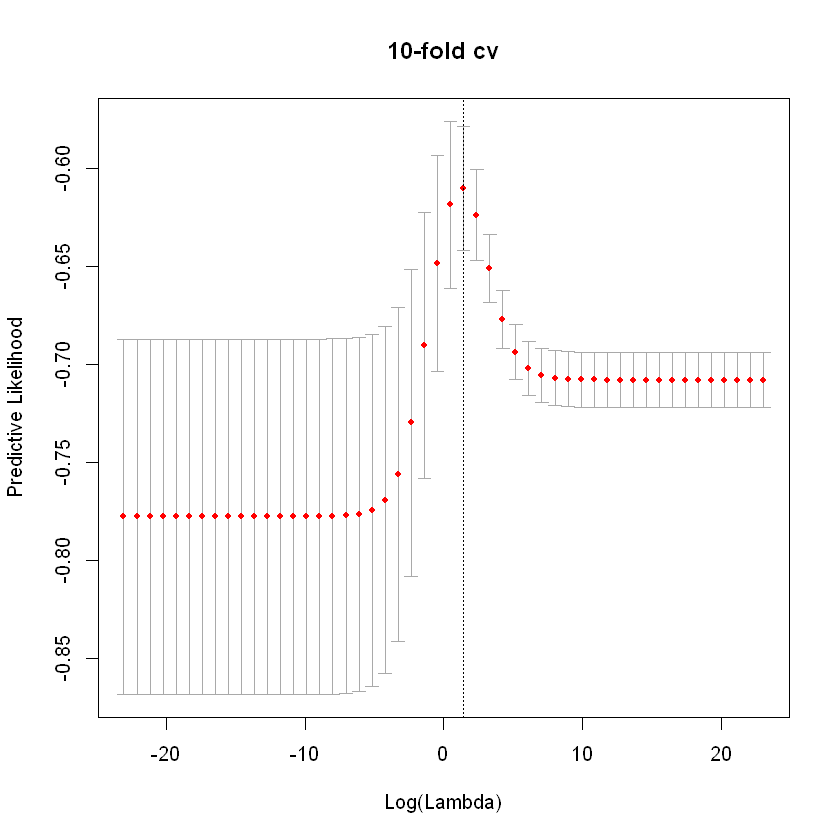

In [29]:
plot(nfold_10,main="10-fold cv")